# Datacamp CapGemini - Novotel Challenge

We are given the task to predict the rating of a Novotel hotel based on reviews scrapped from the web. In order to do this, we must start by applying some various NLP methods to extract valuable insights on how we're going to use the data at hand to accomplish this goal.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import numpy as np

import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE

## 1. EDA - Extracting insights using NLP

In this section you will find all the exploration we have done on our data, they will dictate what model we'll use and how we implement it.

### 1.1 Loading the data

In [60]:
data = pd.read_csv('prediction_challenge_practice_with_rating.csv', engine='python')
data.head()

,hotel_name,trip_date,title,review,rating
0,Novotel Canberra,June 2015,A great choice in Canberra,"A central, clean, modern hotel with great serv...",5
1,Novotel Bangkok Platinum Pratunam,May 2017,Simply Superb,Well this is one of the best hotels we have st...,5
2,Novotel Melbourne on Collins,August 2012,Very good for a Novotel,Rooms recently refurbished and very comfortabl...,4
3,Novotel Milan Nord Ca Granda,October 2018,Milan tourist hotel,Ok hotel in the north of the City. Good for me...,4
4,Novotel Melbourne on Collins,January 2016,Great location,The hotel is still under renovation. And it w...,4


In [33]:
data.head()
print(data.shape)
#check for Nas:
print("Are there NA's?",data.isnull().values.any())
print('Number of replicates:',len(data) - data.review.nunique())

(117514, 5)
Are there NA's? True
Number of replicates: 3227


So we've got 117514 rows and 4 features to start with. As I see this now, there's possibly two ways e could proceed. Either use a Naïve bayes classifier on the comments themselces, integrating one way or another the title, hotel name and trip data alltogether for each review. Or we could consider extracting features directly from each (year, name of the hotel etc.. ) and apply a tree algorithm (XGBOOST) to get our prediction.

Let's look into detail of the data:

#### 1.1.1 Overall ratings

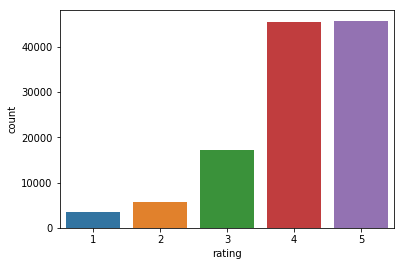

In [34]:
sns.countplot(x="rating",data=data)

There's a vast majority of high ratings in our data, pretty good for Novotel. Let's try to get some details on the bad reviews. 

In [35]:
data.head()

,hotel_name,trip_date,title,review,rating
0,Novotel Canberra,June 2015,A great choice in Canberra,"A central, clean, modern hotel with great serv...",5
1,Novotel Bangkok Platinum Pratunam,May 2017,Simply Superb,Well this is one of the best hotels we have st...,5
2,Novotel Melbourne on Collins,August 2012,Very good for a Novotel,Rooms recently refurbished and very comfortabl...,4
3,Novotel Milan Nord Ca Granda,October 2018,Milan tourist hotel,Ok hotel in the north of the City. Good for me...,4
4,Novotel Melbourne on Collins,January 2016,Great location,The hotel is still under renovation. And it w...,4


In [36]:
data.set_index(['rating','review'],inplace=True)

#group by and get a count column:
data2 = pd.DataFrame(data.groupby(['rating','review']).size())
data2.reset_index(inplace=True)
data2.columns=['rating','review',"count"]
print("max amount of replicates :",data2['count'].max())

#reset the index for the main data frame:
data.reset_index(inplace=True)

max amount of replicates : 2


The max amount of replicates is 2, let's try to see if there's any rating for which this might be more frequent:

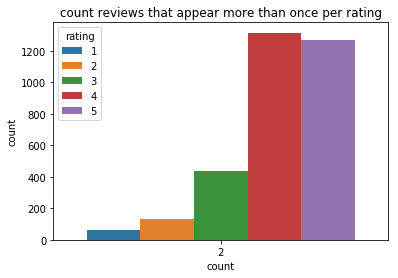

In [37]:
# isolating replicas
i = data2.iloc[:,2] > 1
data2 = data2[i]

#generate count plot:
sns.countplot(x="count",hue="rating",data=data2)
plt.title('count reviews that appear more than once per rating')
plt.show()

Seems to be higher for higher rankings, although this might purely be due to the fact there's more higher rating reviews.

#### 1.1.2 Length of reviews

Let's have a look at how the length of of the reviews are distributed accross the ratings:

/Users/laks/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


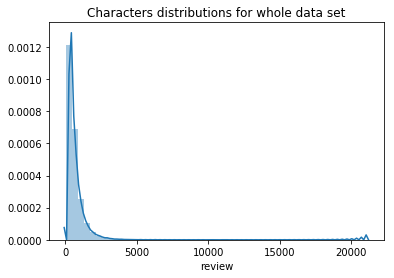

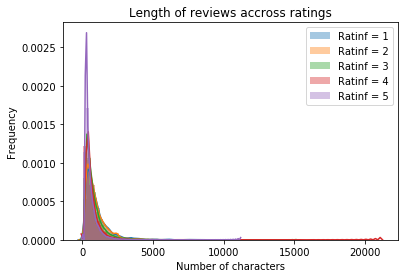

In [38]:
# Overall length
sns.distplot(data['review'].apply(len))
plt.title('Characters distributions for whole data set')
plt.show()

#spam:
r1 = data.loc[:,"rating"]==1
data_r1=data[r1]
sns.distplot(data_r1['review'].apply(len),label="Ratinf = 1")

r2 = data.loc[:,"rating"]==2
data_r2=data[r2]
sns.distplot(data_r2['review'].apply(len),label="Ratinf = 2")

r3 = data.loc[:,"rating"]==3
data_r3=data[r3]
sns.distplot(data_r3['review'].apply(len),label="Ratinf = 3")

r4 = data.loc[:,"rating"]==4
data_r4=data[r4]
sns.distplot(data_r4['review'].apply(len),label="Ratinf = 4")

r5 = data.loc[:,"rating"]==5
data_r5=data[r5]
ax = sns.distplot(data_r5['review'].apply(len),label="Ratinf = 5")

plt.legend()
plt.title('Length of reviews accross ratings')
ax.set(xlabel='Number of characters', ylabel='Frequency')
plt.show()

No distinguishing distributions, all the same length approximatetly

In [92]:
data.head()

,hotel_name,trip_date,title,review,rating,clean,clean_tokens
0,Novotel Canberra,June 2015,A great choice in Canberra,"A central, clean, modern hotel with great serv...",5,"[central, clean, modern, great, service, welco...","[central, clean, modern, great, service, welco..."
1,Novotel Bangkok Platinum Pratunam,May 2017,Simply Superb,Well this is one of the best hotels we have st...,5,"[well, best, hotels, stayed, everything, great...","[well, best, hotels, stayed, everything, great..."
2,Novotel Melbourne on Collins,August 2012,Very good for a Novotel,Rooms recently refurbished and very comfortabl...,4,"[rooms, recently, refurbished, comfortable, cl...","[rooms, recently, refurbished, comfortable, cl..."
3,Novotel Milan Nord Ca Granda,October 2018,Milan tourist hotel,Ok hotel in the north of the City. Good for me...,4,"[north, city, good, metro, bus, tram, links, ...","[north, city, good, metro, bus, tram, links, m..."
4,Novotel Melbourne on Collins,January 2016,Great location,The hotel is still under renovation. And it w...,4,"[still, renovation, quite, time, they\, re, b...","[still, renovation, quite, time, they\, re, bu..."


In [61]:
data['try'] = data['review'] + " " + data['title'] + " " + data['trip_date'] + " " + data['hotel_name']

In [62]:
data['try'][0]

'A central, clean, modern hotel with great service, a welcoming Team (thank you JJ)The gym is small but fully equipped and the pool is excellent. A love a hotel that has a separate shower and no shower curtain-tick-the shower is huge and ceiling to floor modern tiles and glass!!a Big comfortable bed and lots of pillows-YES!!THnakyou team for a great stay in Canberrra A great choice in Canberra  June 2015 Novotel Canberra'

### Insights on words

In [63]:
stopW = stopwords.words('english')
stopW = stopW + ['hotel','room','would','one','also','staff','stay','novotel','service','told']
special_characters = ["@", "/", "#", ".", ",", "!", "?", "(", ")",
                      "-", "_","’","'", "\"", ":","=","+","&"
                      ,"`","*","0","1","2","3","4","5",
                      "6","7","8","9","'",'.','‘',';']
transformation_sc_dict = {initial:" " for initial in special_characters}

def preprocessing(sms):
  
    # Tokenization
    tokens = word_tokenize(sms)
    
    # Deleting words with  only one caracter
    tokens = [token for token in tokens if len(token)>2]
    
    # stopwords + lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stopW]   
    
    # Deleting specific characters
    tokens = [token.translate(str.maketrans(transformation_sc_dict)) for token in tokens]
        
    return tokens

In [42]:
# Creating a new column swith tokenized reviews
data['clean'] = data['review'].apply(preprocessing)
data.head()

,rating,review,hotel_name,trip_date,title,try,clean
0,5,"A central, clean, modern hotel with great serv...",Novotel Canberra,June 2015,A great choice in Canberra,"A central, clean, modern hotel with great serv...","[central, clean, modern, great, welcoming, tea..."
1,5,Well this is one of the best hotels we have st...,Novotel Bangkok Platinum Pratunam,May 2017,Simply Superb,Well this is one of the best hotels we have st...,"[well, best, hotels, stayed, everything, great..."
2,4,Rooms recently refurbished and very comfortabl...,Novotel Melbourne on Collins,August 2012,Very good for a Novotel,Rooms recently refurbished and very comfortabl...,"[rooms, recently, refurbished, comfortable, cl..."
3,4,Ok hotel in the north of the City. Good for me...,Novotel Milan Nord Ca Granda,October 2018,Milan tourist hotel,Ok hotel in the north of the City. Good for me...,"[north, city, good, metro, bus, tram, links, ..."
4,4,The hotel is still under renovation. And it w...,Novotel Melbourne on Collins,January 2016,Great location,The hotel is still under renovation. And it w...,"[still, renovation, quite, time, they\, re, b..."


In [43]:
# creating a list with all reviews and more pre-processing
tokens = data.clean.tolist()
tokens = [[text.strip() for text in token] for token in tokens]
clean_tokens = [[word for word in token if word != ''] for token in tokens]
data['clean_tokens'] = clean_tokens

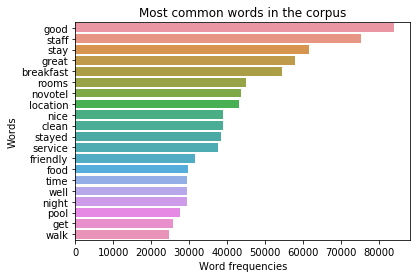

6401061


In [62]:
def plot_frequent_words(list_of_words):    
    dist = nltk.FreqDist(list_of_words)
    X = [nb[1] for nb in dist.most_common(20)]
    y = [nb[0] for nb in dist.most_common(20)]
    ax = sns.barplot(X,y)
    ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
    plt.show()

all_words = []
for tokens in clean_tokens:
    for word in tokens:
        all_words.append(word)
    
plot_frequent_words(all_words)
print(len(all_words))

Here there's some stopwords we could add. Let's have a look at the main words depending on the rating before re-arranging our pre-processing!

#### For rating = 1

In [69]:
r1 = data.loc[:,"rating"]==1
data_r1=data[r1]

data_r1['clean'] = data_r1['review'].apply(preprocessing)
# creating a list with all reviews and more pre-processing
tokens_r1 = data_r1.clean.tolist()
tokens_r1 = [[text.strip() for text in token] for token in tokens_r1]
clean_tokens_r1 = [[word for word in token if word != ''] for token in tokens_r1]
data_r1['clean_tokens'] = clean_tokens_r1

all_words_r1 = []
for tokens in clean_tokens_r1:
    for word in tokens:
        all_words_r1.append(word)

/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### For rating = 2

In [45]:
r2 = data.loc[:,"rating"]==2
data_r2=data[r2]

data_r2['clean'] = data_r2['review'].apply(preprocessing)
# creating a list with all reviews and more pre-processing
tokens_r2 = data_r2.clean.tolist()
tokens_r2 = [[text.strip() for text in token] for token in tokens_r2]
clean_tokens_r2 = [[word for word in token if word != ''] for token in tokens_r2]
data_r2['clean_tokens'] = clean_tokens_r2

all_words_r2 = []
for tokens in clean_tokens_r2:
    for word in tokens:
        all_words_r2.append(word) 

/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### For rating = 3

In [46]:
r3 = data.loc[:,"rating"]==3
data_r3=data[r3]

data_r3['clean'] = data_r3['review'].apply(preprocessing)
# creating a list with all reviews and more pre-processing
tokens_r3 = data_r3.clean.tolist()
tokens_r3 = [[text.strip() for text in token] for token in tokens_r3]
clean_tokens_r3 = [[word for word in token if word != ''] for token in tokens_r3]
data_r3['clean_tokens'] = clean_tokens_r3

all_words_r3 = []
for tokens in clean_tokens_r3:
    for word in tokens:
        all_words_r3.append(word)

/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### For rating = 4

In [47]:
r4 = data.loc[:,"rating"]==4
data_r4=data[r4]

data_r4['clean'] = data_r4['review'].apply(preprocessing)
# creating a list with all reviews and more pre-processing
tokens_r4 = data_r4.clean.tolist()
tokens_r4 = [[text.strip() for text in token] for token in tokens_r4]
clean_tokens_r4 = [[word for word in token if word != ''] for token in tokens_r4]
data_r4['clean_tokens'] = clean_tokens_r4

all_words_r4 = []
for tokens in clean_tokens_r4:
    for word in tokens:
        all_words_r4.append(word)

/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### For rating = 5

In [48]:
r5 = data.loc[:,"rating"]==5
data_r5=data[r5]

data_r5['clean'] = data_r5['review'].apply(preprocessing)
# creating a list with all reviews and more pre-processing
tokens_r5 = data_r5.clean.tolist()
tokens_r5 = [[text.strip() for text in token] for token in tokens_r5]
clean_tokens_r5 = [[word for word in token if word != ''] for token in tokens_r5]
data_r5['clean_tokens'] = clean_tokens_r5

all_words_r5 = []
for tokens in clean_tokens_r5:
    for word in tokens:
        all_words_r5.append(word)

/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/laks/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Visualizing most frequent words according to rating:

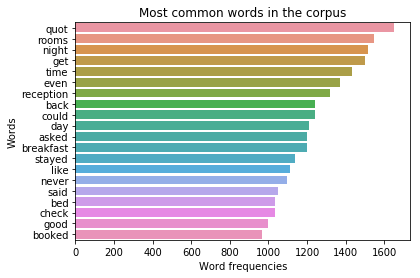

276676


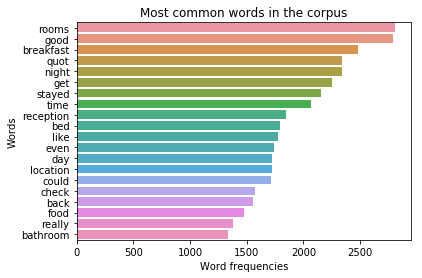

426592


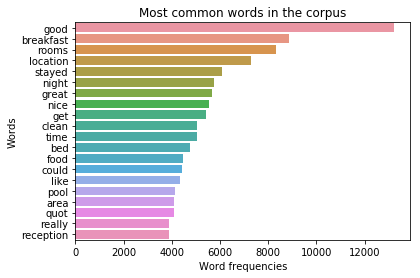

1102772


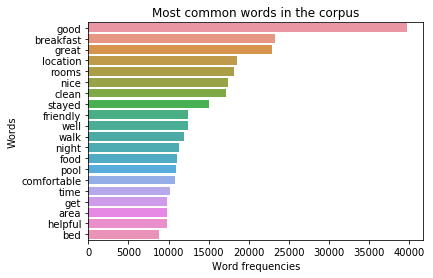

2340207


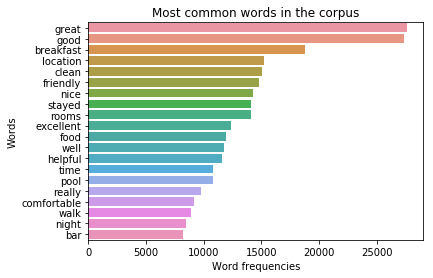

2029561


In [91]:
plot_frequent_words(all_words_r1)
print(len(all_words_r1))
plot_frequent_words(all_words_r2)
print(len(all_words_r2))
plot_frequent_words(all_words_r3)
print(len(all_words_r3))
plot_frequent_words(all_words_r4)
print(len(all_words_r4))
plot_frequent_words(all_words_r5)
print(len(all_words_r5))

## Manual train/test split before oversampling!

In [11]:
msk = np.random.rand(len(data)) < 0.8

train = data[msk]

test = data[~msk]

r5_train = train.loc[:,"rating"]==5
r5_test = test.loc[:,"rating"]==5
train_r5=train[r5_train]
test_r5=test[r5_test]

r5_train = train.loc[:,"rating"]==5
r5_test = test.loc[:,"rating"]==5
train_r4=train[r5_train]
test_r4=test[r5_test]

r3_train = train.loc[:,"rating"]==3
r3_test = test.loc[:,"rating"]==3
train_r3=train[r3_train]
test_r3=test[r3_test]

r2_train = train.loc[:,"rating"]==2
r2_test = test.loc[:,"rating"]==2
train_r2=train[r2_train]
test_r2=test[r2_test]

r1_train = train.loc[:,"rating"]==1
r1_test = test.loc[:,"rating"]==1
train_r1=train[r1_train]
test_r1=test[r1_test]

print("rating = 1", len(train_r1))
print("rating = 2", len(train_r2))
print("rating = 3", len(train_r3))
print("rating = 4", len(train_r4))
print("rating = 5", len(train_r5))
print("rating = 1", len(test_r1))
print("rating = 2", len(test_r2))
print("rating = 3", len(test_r3))
print("rating = 4", len(test_r4))
print("rating = 5", len(test_r5))

train1 = train_r1.append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1).append(train_r1)
test1 = test_r1.append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1).append(test_r1)
train2 = train_r2.append(train_r2).append(train_r2).append(train_r2).append(train_r2).append(train_r2).append(train_r2).append(train_r2)
test2 = test_r2.append(test_r2).append(test_r2).append(test_r2).append(test_r2).append(test_r2).append(test_r2).append(test_r2)
train3 = train_r3.append(train_r3).append(train_r3)
test3 = test_r3.append(test_r3).append(test_r3)
train4 = train_r4.copy()
test4 = test_r4.copy()
train5 = train_r5.copy()
test5 = test_r5.copy()

print("rating = 1", len(train1))
print("rating = 2", len(train2))
print("rating = 3", len(train3))
print("rating = 4", len(train4))
print("rating = 5", len(train5))
print("rating = 1", len(test1))
print("rating = 2", len(test2))
print("rating = 3", len(test3))
print("rating = 4", len(test4))
print("rating = 5", len(test5))

data_test = test1.append(test2).append(test3).append(test4).append(test5).dropna()
data_train = train1.append(train2).append(train3).append(train4).append(train5).dropna()

X_train = data_train['try']
X_test = data_test['try']
y_train = data_train['rating']
y_test = data_test['rating']

## Oversampling before train/test split

In [65]:
r5 = data.loc[:,"rating"]==5
data_r5=data[r5]

r4 = data.loc[:,"rating"]==4
data_r4=data[r4]

r3 = data.loc[:,"rating"]==3
data_r3=data[r3]

r2 = data.loc[:,"rating"]==2
data_r2=data[r2]

r1 = data.loc[:,"rating"]==1
data_r1=data[r1]

In [66]:
print("rating = 1", len(data_r1))
print("rating = 2", len(data_r2))
print("rating = 3", len(data_r3))
print("rating = 4", len(data_r4))
print("rating = 5", len(data_r5))

rating = 1 3467
rating = 2 5605
rating = 3 17287
rating = 4 45399
rating = 5 45756


In [67]:
rating1 = data_r1.append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1).append(data_r1)

In [68]:
rating2 = data_r2.append(data_r2).append(data_r2).append(data_r2).append(data_r2).append(data_r2).append(data_r2).append(data_r2)

In [69]:
rating3 = data_r3.append(data_r3).append(data_r3)

In [70]:
rating4 = data_r4.copy()

In [71]:
rating5 = data_r5.copy()

In [74]:
print("rating = 1", len(rating1))
print("rating = 2", len(rating2))
print("rating = 3", len(rating3))
print("rating = 4", len(rating4))
print("rating = 5", len(rating5))

rating = 1 45071
rating = 2 44840
rating = 3 51861
rating = 4 45399
rating = 5 45756


In [75]:
data = rating1.append(rating2).append(rating3).append(rating4).append(rating5)

## 2. Naïve bayes classifier

### 2.1 Data processing

##### 2.1.1 Train/test split

In [116]:
dataNB = data.dropna()
X = dataNB['try']
y = dataNB['rating']

#make train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

##### 2.1.2 Defining pre-processing to apply

In [78]:
def clean_text(text):
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='"\'%&()*,-./:;<=>?[\\]^_`{|}~\t\n$€£`~|+=-"@#"""'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

stopW = stopwords.words('english')
stopW += "Novotel"

##### 2.1.3 Wordcount vectorization

In [94]:
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text)

data_train_count = vectorizer.fit_transform(X_train)
data_test_count = vectorizer.transform(X_test)

##### 2.1.4 TF-IDF Vectorization

In [83]:
vectorizer = TfidfVectorizer(
    stop_words=stopW,
    preprocessor=clean_text,
    sublinear_tf=True,
    min_df=1,
    norm='l2',
    ngram_range=(2, 8))

data_train_tfidf = vectorizer.fit_transform(X_train)
data_test_tfidf = vectorizer.transform(X_test)

### 2.2 Building the model

##### 2.2.1 Using WordCount

In [103]:
clf_count = MultinomialNB()
clf_count.fit(data_train_count,y_train)

#predict on test data:
pred_count = clf_count.predict(data_test_count)
pred_count_prob = clf_count.predict_proba(data_test_count)[:,1]

##### 2.2.2 Using TF-IDF

In [108]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(data_train_tfidf,y_train)

#predict on test data:
pred_tfidf = clf_tfidf.predict(data_test_tfidf)
pred_count_tfidf = clf_tfidf.predict_proba(data_test_tfidf)[:,1]

### 2.3 Model assesment

##### 2.3.1 Using Wordcount

In [105]:
print("\n")
print("Using count vectorization")
print("\n")
acc_count = accuracy_score(y_test,pred_count)
prec_count = precision_score(y_test, pred_count,average='weighted')
sens_count = recall_score(y_test,pred_count,average='weighted')
f1_count = f1_score(y_test, pred_count,average='weighted')

print("Accuracy :", acc_count)
print("Precision :", prec_count)
print("Sensitivity :", sens_count)
print("F1 Score :", f1_count)



Using count vectorization


Accuracy : 0.6763603463874887
Precision : 0.6820847539712532
Sensitivity : 0.6763603463874887
F1 Score : 0.6782891062408106


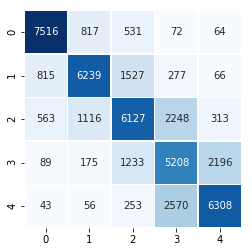

In [106]:
confusion = metrics.confusion_matrix(y_test, pred_count)
sns.heatmap(confusion, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

##### 2.3.2 Using TF-IDF 

In [109]:
print("\n")
print("Using TF-IDF vectorization")
print("\n")

acc_tfidf = accuracy_score(y_test,pred_tfidf)
prec_tfidf = precision_score(y_test, pred_tfidf,average='weighted')
sens_tfidf = recall_score(y_test,pred_tfidf,average='weighted')
f1_tfidf = f1_score(y_test, pred_tfidf,average='weighted')

print("Accuracy :", acc_tfidf)
print("Precision :", prec_tfidf)
print("Sensitivity :", sens_tfidf)
print("F1 Score :", f1_tfidf)



Using TF-IDF vectorization


Accuracy : 0.8343242428159062
Precision : 0.8283760142608955
Sensitivity : 0.8343242428159062
F1 Score : 0.8237710502606431


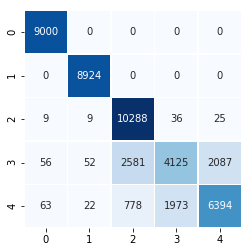

In [110]:
confusion = metrics.confusion_matrix(y_test, pred_tfidf)
sns.heatmap(confusion, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words=stopW,
    preprocessor=clean_text,
    sublinear_tf=True,
    min_df=1,
    norm='l2',
    ngram_range=(2, 8))

data_train_tfidf = vectorizer.fit_transform(X_train)
data_test_tfidf = vectorizer.transform(X_test)

In [118]:
from sklearn.pipeline import Pipeline

In [119]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stopW,
    preprocessor=clean_text,
    sublinear_tf=True,
    min_df=1,
    norm='l2',
    ngram_range=(2, 8))
nb = MultinomialNB()
tfidf_nb_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('nb', nb)])

# Internally your X_train will be automatically converted to tfidf 
# and that will be passed to lr
tfidf_nb_pipe.fit(X_train, y_train)

# Similarly here only transform() will be called internally for tfidfvectorizer
# And that data will be passed to lr.predict()


NameError: name 'tfidf_lr_pipe' is not defined

In [ ]:
filename = 'finalized_model.sav'
joblib.dump(tfidf_nb_pipe, filename)

In [ ]:
y_preds = tfidf_nb_pipe.predict(X_test)

# Now you can save this pipeline alone (which will save all its internal parts)
filename = 'finalized_model.sav'
joblib.dump(tfidf_nb_pipe, filename)

In [ ]:
data_2 = pd.read_csv('prediction_challenge_evaluate_without_rating.csv')
data_2.head()
data_2['try'] = data_2['review'] + " " + data_2['title'] + " " + data_2['trip_date'] + " " + data_2['hotel_name']
new_x = data_2['try']

In [ ]:
loaded_pipe = joblib.load("finalized_model.sav")
result = loaded_model.predict(new_x)

In [ ]:
vectorizer = TfidfVectorizer(
    stop_words=stopW,
    preprocessor=clean_text,
    sublinear_tf=True,
    min_df=1,
    norm='l2',
    ngram_range=(2, 8))

data_2_tfidf = vectorizer.transform(data_2['try'])

In [ ]:
pred_tfidf = clf_tfidf.predict()

## KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 23).fit(data_train_count,y_train)
  
# creating a confusion matrix 
knn_predictions = knn.predict(data_test_count)  
cm = confusion_matrix(y_test, knn_predictions) 
sns.heatmap(cm, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

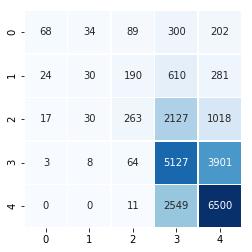

In [146]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 23).fit(data_train_tfidf,y_train)
  
# creating a confusion matrix 
knn_predictions = knn.predict(data_test_tfidf)  
cm = confusion_matrix(y_test, knn_predictions) 
sns.heatmap(cm, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

### To test which model suits best

/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


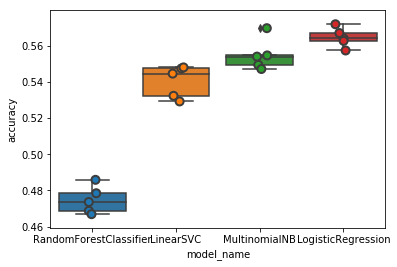

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, data_train_tfidf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## Logistic regression

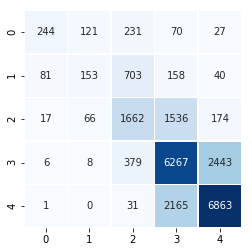

In [152]:
logr = LogisticRegression(random_state=0).fit(data_train_tfidf, y_train)
logr_predictions = logr.predict(data_test_tfidf)  
cm = confusion_matrix(y_test, logr_predictions) 
sns.heatmap(cm, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

In [153]:
acc_tfidf = accuracy_score(y_test,logr_predictions)
prec_tfidf = precision_score(y_test, logr_predictions,average='weighted')
sens_tfidf = recall_score(y_test,logr_predictions,average='weighted')
f1_tfidf = f1_score(y_test, logr_predictions,average='weighted')

print("Accuracy :", acc_tfidf)
print("Precision :", prec_tfidf)
print("Sensitivity :", sens_tfidf)
print("F1 Score :", f1_tfidf)

Accuracy : 0.6478290539964173
Precision : 0.6398473027699041
Sensitivity : 0.6478290539964173
F1 Score : 0.6368544307587087


Our model is putting too much weight on the higher rankings... We could go around this problem by subsampling each ranking so that the number orf reviews per class is the same for all rankings

## Re-weighting samples

In [207]:
# Separating data according to rating
r1 = data.loc[:,"rating"]==1
data_r1=data[r1]
r2 = data.loc[:,"rating"]==2
data_r2=data[r2]
r3 = data.loc[:,"rating"]==3
data_r3=data[r3]
r4 = data.loc[:,"rating"]==4
data_r4=data[r4]
r5 = data.loc[:,"rating"]==5
data_r5=data[r5]
print("We will take the number of rows having rating = 1",data_r1.shape,data_r2.shape,data_r3.shape,data_r4.shape,data_r5.shape)

# Subsampling to the max amount of rows of data having rating = 1
df1 = data_r1.sample(n = data_r1.shape[0],random_state = 11)
df2 = data_r2.sample(n = data_r1.shape[0],random_state = 11)
df3 = data_r3.sample(n = data_r1.shape[0],random_state = 11)
df4 = data_r4.sample(n = data_r1.shape[0],random_state = 11)
df5 = data_r5.sample(n = data_r1.shape[0],random_state = 11)

# Grouping in a same dataframe all ratings
temp1 = df1.append(df2)
temp2 = temp1.append(df3)
temp3 = temp2.append(df4)
newdata = temp3.append(df5)

We will take the number of rows having rating = 1 (3467, 6) (5605, 6) (17287, 6) (45399, 6) (45756, 6)


In [208]:
don = newdata.dropna()
X = don['try']
y = don['rating']

#make train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

## Multinomial NB

#### TF-IDF vectorization

In [212]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    sublinear_tf=True,
    min_df=5,
    norm='l2',
    ngram_range=(1, 2))

data_train_tfidf = vectorizer.fit_transform(X_train)
data_test_tfidf = vectorizer.transform(X_test)

KeyboardInterrupt: 

In [173]:
clf_tfidf = MultinomialNB()
clf_tfidf.fit(data_train_tfidf,y_train)

#predict on test data:
pred_tfidf = clf_tfidf.predict(data_test_tfidf)
prob_tfidf = clf_tfidf.predict_proba(data_test_tfidf)[:,1]

In [174]:
acc_tfidf = accuracy_score(y_test,pred_tfidf)
prec_tfidf = precision_score(y_test, pred_tfidf,average='weighted')
sens_tfidf = recall_score(y_test,pred_tfidf,average='weighted')
f1_tfidf = f1_score(y_test, pred_tfidf,average='weighted')

print("Accuracy :", acc_tfidf)
print("Precision :", prec_tfidf)
print("Sensitivity :", sens_tfidf)
print("F1 Score :", f1_tfidf)



Using TF-IDF vectorization


Accuracy : 0.5521134916039374
Precision : 0.5501718688170422
Sensitivity : 0.5521134916039374
F1 Score : 0.5477576752705731


#### Wordcount vectorization

In [176]:
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text)

data_train_count = vectorizer.fit_transform(X_train)
data_test_count = vectorizer.transform(X_test)

In [177]:
clf_count = MultinomialNB()
clf_count.fit(data_train_count,y_train)

#predict on test data:
pred_count = clf_count.predict(data_test_count)
pred_count_prob = clf_count.predict_proba(data_test_count)
print("\n")
print("Using count vectorization")
print("\n")
acc_count = accuracy_score(y_test,pred_count)
prec_count = precision_score(y_test, pred_count,average='weighted')
sens_count = recall_score(y_test,pred_count,average='weighted')
f1_count = f1_score(y_test, pred_count,average='weighted')

print("Accuracy :", acc_count)
print("Precision :", prec_count)
print("Sensitivity :", sens_count)
print("F1 Score :", f1_count)



Using count vectorization


Accuracy : 0.5356108859293572
Precision : 0.5368166799621399
Sensitivity : 0.5356108859293572
F1 Score : 0.5357939338006573


## Logistic regression prediction

/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


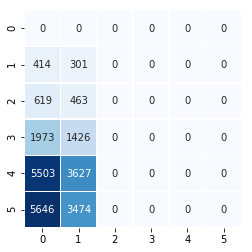

In [29]:
logr = LogisticRegression(random_state=0).fit(x_train_words_sm, y_train_words_sm)
logr_predictions = logr.predict(data_test_tfidf)  
cm = confusion_matrix(y_test, logr_predictions) 
sns.heatmap(cm, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

In [214]:
acc_logr = accuracy_score(y_test,logr_predictions)
prec_logr = precision_score(y_test, logr_predictions,average='weighted')
sens_logr = recall_score(y_test,logr_predictions,average='weighted')
f1_logr = f1_score(y_test, logr_predictions,average='weighted')

print("Accuracy :", acc_logr)
print("Precision :", prec_logr)
print("Sensitivity :", sens_logr)
print("F1 Score :", f1_logr)


Accuracy : 0.5738274464389114
Precision : 0.5680621786395976
Sensitivity : 0.5738274464389114
F1 Score : 0.5680590020226134


# Oversampling

In [4]:
def clean_text(text):
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='"\'%&()*,-./:;<=>?[\\]^_`{|}~\t\n$€£`~|+=-"@#"""'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

Retrieve data:

In [5]:
dataNB = data.dropna()
X = dataNB['try']
y = dataNB['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

Vectorize data:

In [6]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    sublinear_tf=True,
    min_df=2,
    norm='l2',
    ngram_range=(1, 5))

data_train_tfidf = vectorizer.fit_transform(X_train)
data_test_tfidf = vectorizer.transform(X_test)

Then over sample using SMOTE

In [7]:
sm = SMOTE(random_state=12)
x_train_words_sm, y_train_words_sm = sm.fit_sample(data_train_tfidf, y_train)

Count the number of occurences in the y_train sets to ensure that the oversampling worked

In [8]:
class_check_woSMOTE = Counter(y_train)
class_check_words = Counter(y_train_words_sm)

checking which models perform the best

/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


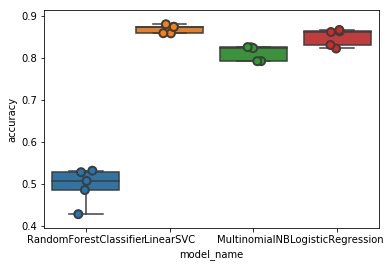

In [10]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, x_train_words_sm, y_train_words_sm, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [25]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
#x_train_words_sm, y_train_words_sm = make_classification(random_state = 0,n_features = 1373982)
clf = LinearSVC(random_state=0)
clf.fit(x_train_words_sm, y_train_words_sm)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

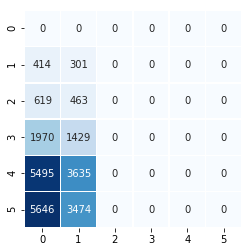

In [27]:
SVC_predictions = clf.predict(data_test_tfidf)

cm = confusion_matrix(y_test, SVC_predictions) 
sns.heatmap(cm, annot = True, cbar = False, square = True, cmap = 'Blues', fmt = 'g', linewidths = 0.5)

In [28]:
acc_logr = accuracy_score(y_test,SVC_predictions)
prec_logr = precision_score(y_test, SVC_predictions,average='weighted')
sens_logr = recall_score(y_test,SVC_predictions,average='weighted')
f1_logr = f1_score(y_test, SVC_predictions,average='weighted')

print("Accuracy :", acc_logr)
print("Precision :", prec_logr)
print("Sensitivity :", sens_logr)
print("F1 Score :", f1_logr)

Accuracy : 0.012838010748102022
Precision : 0.0009867961389908564
Sensitivity : 0.012838010748102022
F1 Score : 0.0018327199131262743


/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laks/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
data_to_use <- tpehgdb_features

metrics_all <- data.frame()

#leave one participant out cross-validation
results_lr <- rep(NA, nrow(data_to_use))
results_tree <- rep(NA, nrow(data_to_use))
results_svm <- rep(NA, nrow(data_to_use))
results_rf <- rep(NA, nrow(data_to_use))

for(index_subj  in 1:nrow(data_to_use))
{
  #remove subject to validate
  training_data <- data_to_use[-index_subj, ]
  training_data_smote <- SMOTE(preterm ~ . , cbind(training_data[, c("preterm", features)]), k=5, perc.over = 600)
  
  #no need to balance the dataset anymore     
  #select features in the training set
  training_data_formula <- training_data_smote[, c("preterm", features)]
  
  #select features in the validation set
  validation_data <- data_to_use[index_subj, features]
  
  #logistic regression
  glm.fit <- glm(preterm ~.,
                 data = training_data_formula,
                 family = binomial)
  glm.probs <- predict(glm.fit, validation_data, type = "response")
  predictions_lr <- ifelse(glm.probs < 0.5, "t", "f")
  results_lr[index_subj] <- predictions_lr
  
  #classification tree
  tree.fit <- tree(preterm ~.,
                   data = training_data_formula)
  predictions_tree <- predict(tree.fit, validation_data, type = "class")
  results_tree[index_subj] <- predictions_tree
  
  #svm
  svm <- svm(preterm ~.,
             data = training_data_formula
  )
  predictions_svm <- predict(svm, validation_data)
  results_svm[index_subj] <- predictions_svm
  
  #random forest      
  rf <- randomForest(preterm ~.,
                     data = training_data_formula)
  predictions_rf <- predict(rf, validation_data)
  results_rf[index_subj] <- predictions_rf   
}